This file was predominantly created by prompting AI. 

In [421]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import matplotlib.ticker as ticker
from main import evaluate
from opponent import make_opponent
from gymnasium import spaces
from TD3_agent import TD3_Agent
import hockey.hockey_env as hockey_env


In [422]:
# STYLE SETUP
plt.rcParams.update({
    'figure.facecolor':     'white',#'#fafafa',
    'axes.facecolor':       'white', #'#fafafa',
    'axes.edgecolor':       '#cccccc',
    'axes.grid':            True,
    'axes.spines.top':      False,
    'axes.spines.right':    False,
    'axes.xmargin':         0.01,
    'axes.ymargin':         0.0,   
    'grid.alpha':           0.3,
    'grid.color':           '#888888',
    'grid.linestyle':       '--',
    'font.family':          'sans-serif',
    'font.sans-serif':      ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size':            11,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'axes.labelsize':       12,
    'legend.fontsize':      10,
    'legend.frameon':       False,
    #'legend.framealpha':    0.9,
    'legend.edgecolor':     '#cccccc',
    'figure.dpi':           130,
    'savefig.dpi':          200,
    'savefig.bbox':         'tight',
})

COLORS = ['#2176AE', # blue
          '#57A773', # green
          '#D4A843', # yellow
          '#E87EA1', # pink
          '#E05A3A', # orange
          '#8B5FBF', # purple
          '#27EEF5', # turquoise
          '#F52754', # red
          '#B2DE90', # light green
          ]

In [423]:
# Noise-type color mapping (inspired by colored noise spectrum)
NOISE_COLORS = {
    "P":  '#D45B90',  #"#E87EA1",   # pink noise → pink
    "OU": "#C0392B",   # Ornstein-Uhlenbeck ≈ red/brown noise → red
    "G":  "#2B2B2B",   # Gaussian = white noise → dark charcoal
}

def get_noise_color(label: str) -> str:
    first_part = label.split(",")[0].split("\n")[0].strip()
    if first_part.startswith("OU"):
        return NOISE_COLORS["OU"]
    elif first_part.startswith("G"):
        return NOISE_COLORS["G"]
    elif first_part.startswith("P"):
        return NOISE_COLORS["P"]
    return "#333333"

In [424]:
# Extended color mapping: lighter = no PER, darker/saturated = with PER
NOISE_COLORS_FULL = {
    "G":       "#888888",   # light grey
    "G + PER": "#2B2B2B",   # dark charcoal
    "OU":      "#E07060",   # light red
    "OU + PER":"#C0392B",   # dark red
    "P":       "#E8A0B8",   # light pink
    "P + PER": "#D45B90",   # saturated pink
}

def get_noise_color_full(label: str) -> str:
    """Match full label (including +PER) to a shade."""
    clean = label.split("\n")[0].strip()
    if clean in NOISE_COLORS_FULL:
        return NOISE_COLORS_FULL[clean]
    return get_noise_color(label)  # fallback to base color

In [425]:
def get_line_style(label: str) -> dict:
    has_per = "PER" in label
    return {
        "linestyle": "-"  if has_per else (5, (6, 2)),  # solid vs long dash
        "linewidth": 2.0  if has_per else 1.5,
    }

In [426]:
def sort_legend(handles, labels):
    LEGEND_ORDER = ["G", "G + PER", "OU", "OU + PER", "P", "P + PER"]
    order_map = {name: i for i, name in enumerate(LEGEND_ORDER)}
    paired = list(zip(handles, labels))
    paired.sort(key=lambda x: order_map.get(x[1], 999))
    return zip(*paired)

# Load the selected agents

In [427]:
def load_logs(map: dict) -> dict:
    runs = {}
    for label, path in map.items():
        if not os.path.exists(path):
            print(f"skipping {label}: {path} not found")
            continue
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()
        runs[label] = df
    return runs

In [428]:
# load the data 
TRAINING_wins_map = {"weak": {
    "G\n1991359": "/Users/Anne/RL/Hockey-TD3/1991359/logs/win_rate_log.csv", 
    "G + PER\n1991358": "/Users/Anne/RL/Hockey-TD3/1991358/logs/win_rate_log.csv",
    "OU + PER\n1986413": "./1986413/logs/win_rate_log.csv",
    "OU\n1986415": "/Users/Anne/RL/Hockey-TD3/1986415/logs/win_rate_log.csv",
    "P\n1991360": "/Users/Anne/RL/Hockey-TD3/1991360/logs/win_rate_log.csv",
    "P + PER\n1991357": "/Users/Anne/RL/Hockey-TD3/1991357/logs/win_rate_log.csv",
},
"strong": {
    "G + PER\n1986633": "./1986633/logs/win_rate_log.csv",
    "OU + PER\n1986620": "./1986620/logs/win_rate_log.csv",
    "P + PER\n1986341": "./1986341/logs/win_rate_log.csv",
}} 


In [429]:
def wins_map_to_log_map(wins_map: dict) -> dict:
    """Convert win_rate_log.csv paths to training_log.csv paths."""
    return {
        opponent: {
            label: path.replace("win_rate_log.csv", "training_log.csv")
            for label, path in runs.items()
        }
        for opponent, runs in wins_map.items()
    }

TRAINING_log_map = wins_map_to_log_map(TRAINING_wins_map)
TRAINING_log_map

{'weak': {'G\n1991359': '/Users/Anne/RL/Hockey-TD3/1991359/logs/training_log.csv',
  'G + PER\n1991358': '/Users/Anne/RL/Hockey-TD3/1991358/logs/training_log.csv',
  'OU + PER\n1986413': './1986413/logs/training_log.csv',
  'OU\n1986415': '/Users/Anne/RL/Hockey-TD3/1986415/logs/training_log.csv',
  'P\n1991360': '/Users/Anne/RL/Hockey-TD3/1991360/logs/training_log.csv',
  'P + PER\n1991357': '/Users/Anne/RL/Hockey-TD3/1991357/logs/training_log.csv'},
 'strong': {'G + PER\n1986633': './1986633/logs/training_log.csv',
  'OU + PER\n1986620': './1986620/logs/training_log.csv',
  'P + PER\n1986341': './1986341/logs/training_log.csv'}}

In [430]:
def strip_job_ids(wins_map: dict) -> dict:
    """Strip job IDs from labels, keeping only noise + buffer config."""
    cleaned = {}
    for opponent, runs in wins_map.items():
        cleaned[opponent] = {}
        for label, path in runs.items():
            clean_label = label.split("\n")[0].strip()
            cleaned[opponent][clean_label] = path
    return cleaned

TRAINING_wins_map = strip_job_ids(TRAINING_wins_map)
TRAINING_log_map = strip_job_ids(TRAINING_log_map)

In [431]:
weak_runs = load_logs(TRAINING_wins_map["weak"])
strong_runs = load_logs(TRAINING_wins_map["strong"])

weak_training = load_logs(TRAINING_log_map["weak"])
strong_training = load_logs(TRAINING_log_map["strong"])


In [432]:
# check
for label in TRAINING_wins_map["strong"]:
    print(f"{label!r} → {get_noise_color(label)}")

'G + PER' → #2B2B2B
'OU + PER' → #C0392B
'P + PER' → #D45B90


# Win rate across training

In [433]:
EPISODE_MAX = 8_000

In [441]:
def plot_win_rate_comparison(panels: dict, figsize=(14, 5), dpi=100):
    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True, dpi=dpi)
    if n_panels == 1:
        axes = [axes]

    all_handles, all_labels = [], []

    for ax, (panel_title, runs) in zip(axes, panels.items()):
        for i, (label, df) in enumerate(runs.items()):
            c = get_noise_color(label)
            display_label = label.replace("\n", " — ")

            # PER runs get solid lines, non-PER get dashed
            #ls = "-" if "PER" in label else "--"
            line_style = get_line_style(label)

            ax.plot(df["episode"], df["win_rate"], color=c,
                    label=display_label, **line_style)

        ax.set_title(f"Against {panel_title} BasicOpponent")
        ax.set_xlabel("Training episode")
        ax.set_xlim(0, EPISODE_MAX)
        ax.set_ylim(-0.05, 1.05)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1,
                   alpha=0.8)
        ax.axhline(0.55, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
        ax.text(EPISODE_MAX * 0.99, 0.56, "55% threshold",
                ha="right", va="bottom", fontsize=8, color="#aaaaaa")
        
        import matplotlib.ticker as mticker
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

        # collect handles for global legend (avoid duplicates)
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

        #ax.legend(loc="lower right", fontsize=9)

    axes[0].set_ylabel("Win rate")

    sorted_handles, sorted_labels = sort_legend(all_handles, all_labels)
    fig.legend(sorted_handles, sorted_labels,
               loc="center right",
               bbox_to_anchor=(1.08, 0.5))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.18)  # make room for legend

    fig.tight_layout()
    return fig

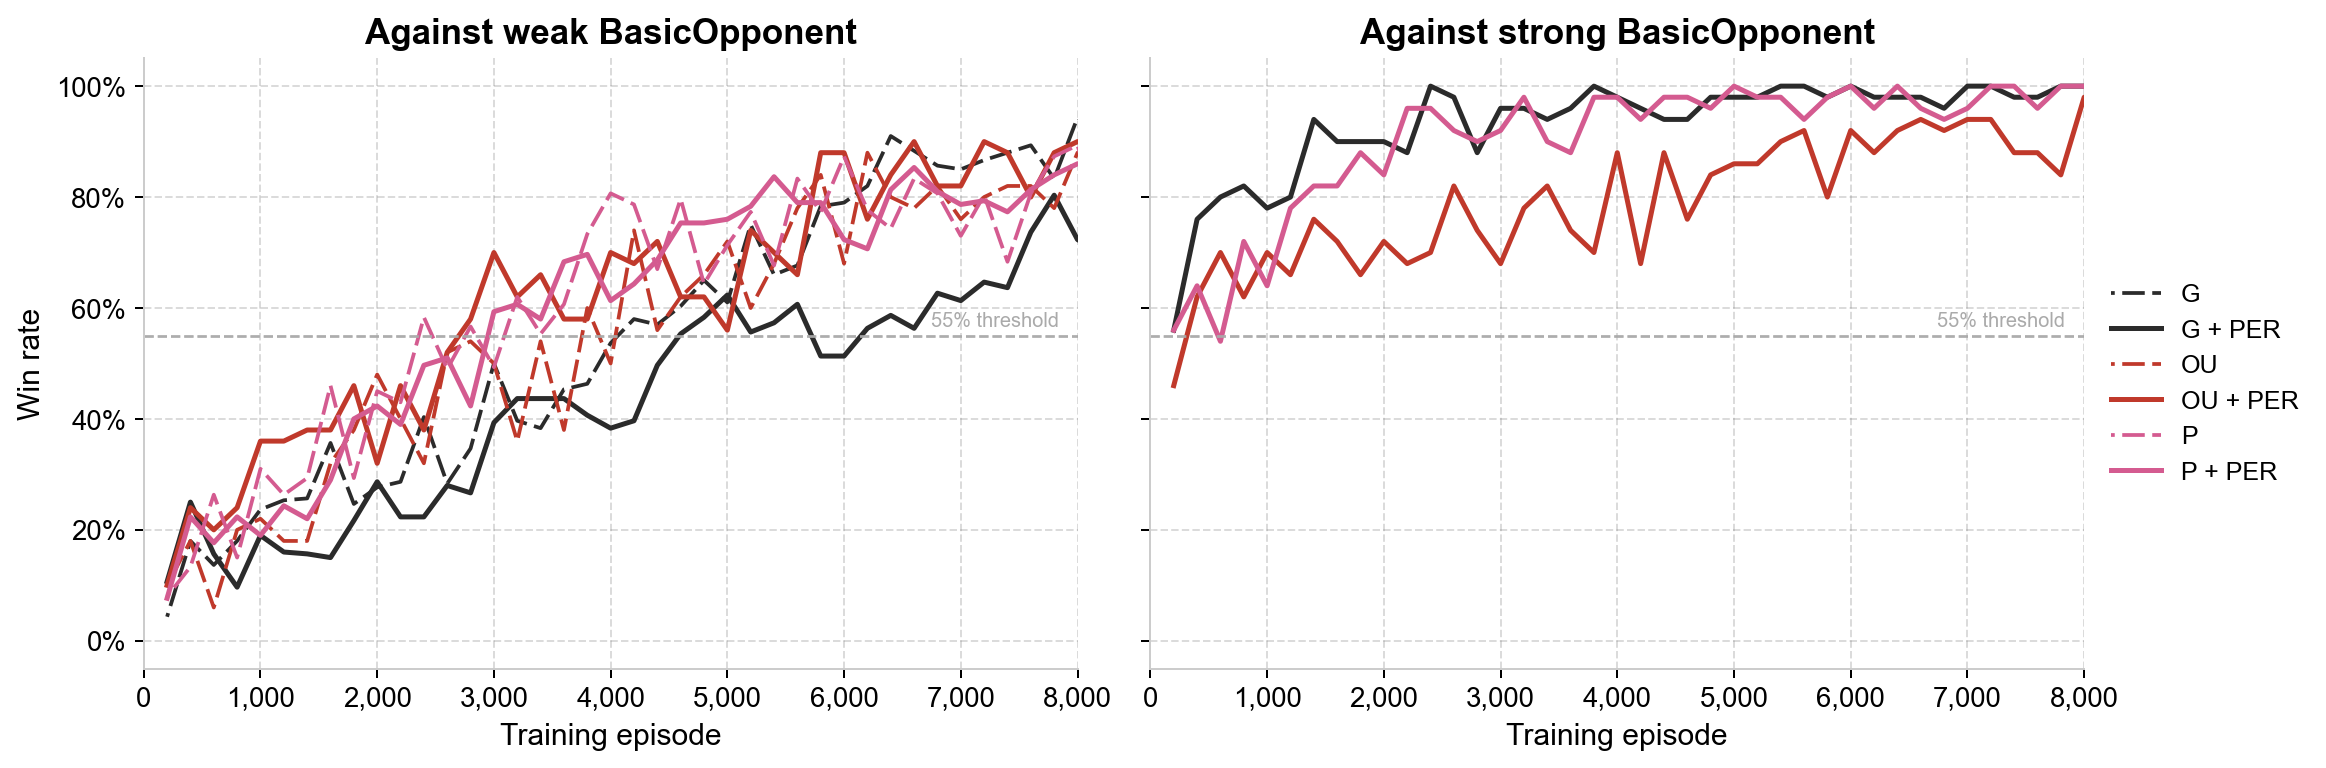

In [440]:
fig = plot_win_rate_comparison(
    {"weak": weak_runs, "strong": strong_runs},
    figsize=(12, 4.4),
    dpi=180  
)
fig.savefig("win_rate_comparison_TD3.pdf")
plt.show()

# Episode length

In [436]:
def get_line_style_episode(label: str) -> dict:
    """For episode length plot: all solid, differentiate only by color."""
    return {"linestyle": "-"}

In [437]:
def plot_episode_length_comparison(panels: dict, smoothing=200, figsize=(12, 4.4), dpi=100):
    n_panels = len(panels)
    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True, dpi=dpi)
    if n_panels == 1:
        axes = [axes]

    all_handles, all_labels = [], []

    for ax, (panel_title, runs) in zip(axes, panels.items()):
        for i, (label, df) in enumerate(runs.items()):
            c = get_noise_color_full(label)
            line_style = get_line_style_episode(label)

            smooth = df["episode_length"].rolling(smoothing, min_periods=1).mean()
            ax.plot(df["episode"], smooth, color=c, linewidth=1,
                    label=label, **line_style)

        ax.axhline(250, color="#aaaaaa", linestyle="--", linewidth=1, alpha=0.8)
        ax.text(EPISODE_MAX * 0.97, 252, "Max (250 steps)",
                ha="right", va="bottom", fontsize=8, color="#aaaaaa")

        ax.set_title(f"Against {panel_title} BasicOpponent")
        ax.set_xlabel("Training episode")
        ax.set_xlim(0, EPISODE_MAX)

        import matplotlib.ticker as mticker
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in all_labels:
                all_handles.append(hi)
                all_labels.append(li)

    axes[0].set_ylabel("Episode length (steps)")

    sorted_handles, sorted_labels = sort_legend(all_handles, all_labels)
    fig.legend(sorted_handles, sorted_labels,
               loc="center right",
               bbox_to_anchor=(1.08, 0.5))
    fig.tight_layout()
    return fig

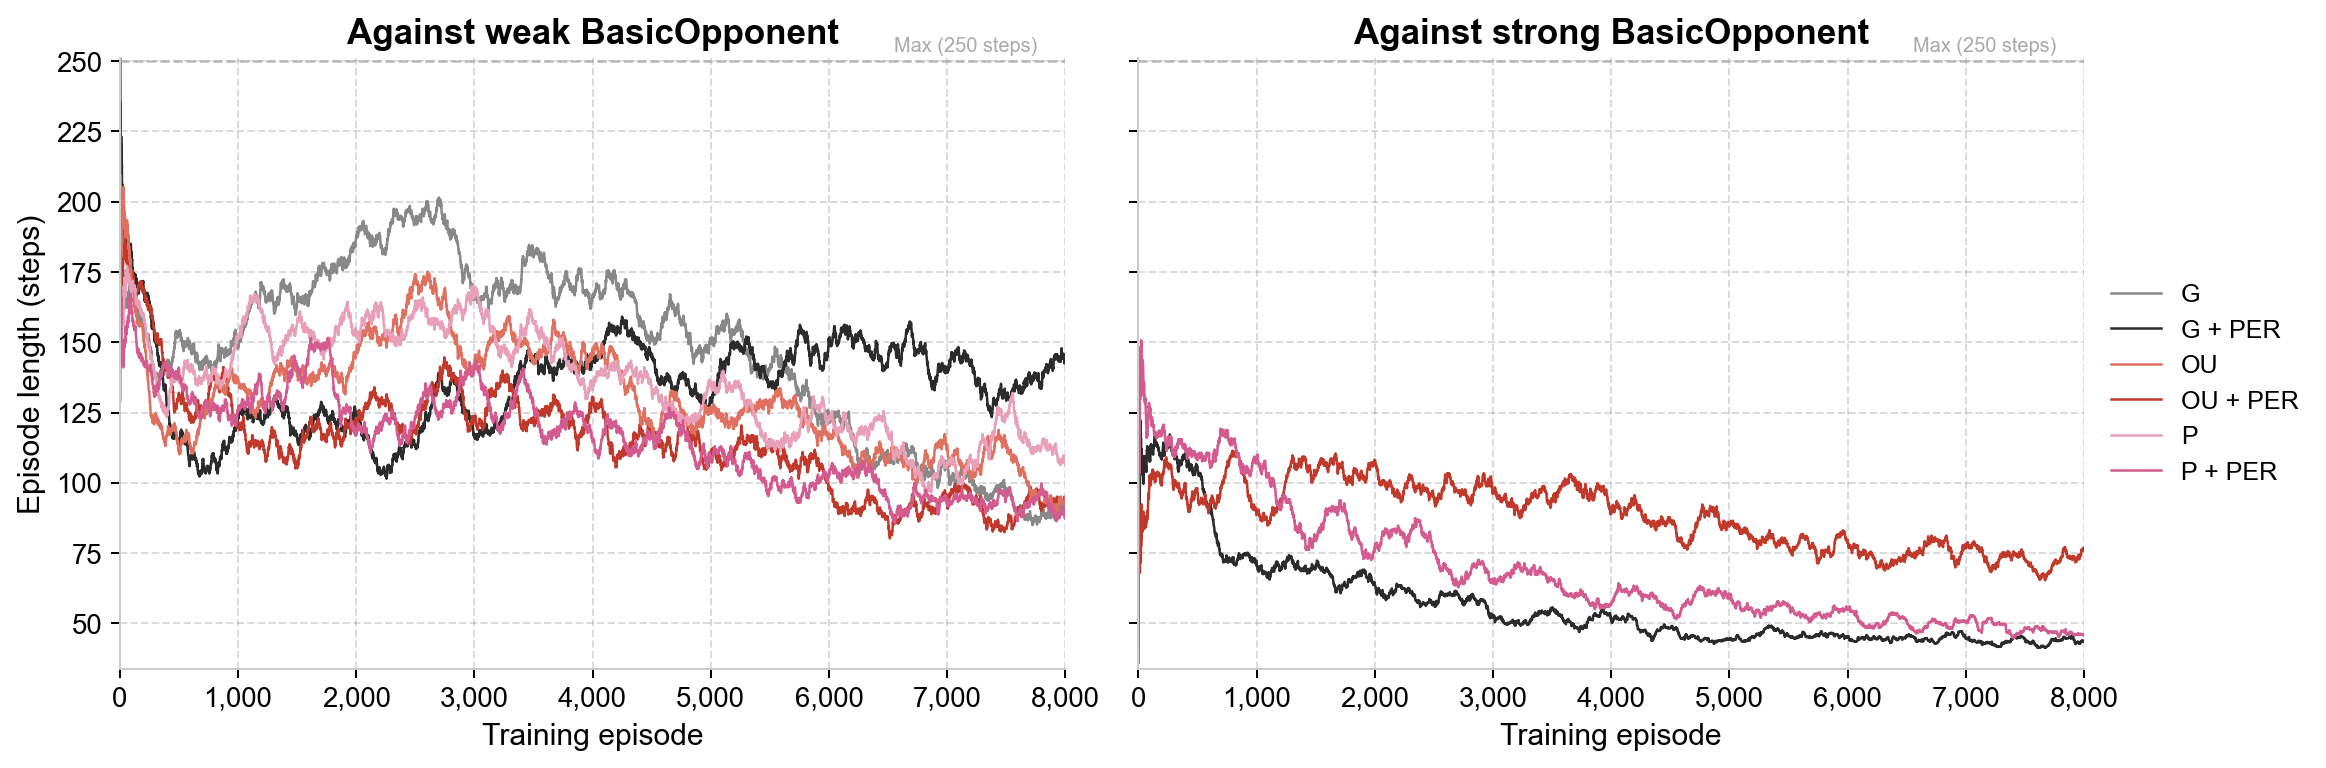

In [438]:
fig = plot_episode_length_comparison(
    {"weak": weak_training, "strong": strong_training},
    smoothing=200,
    figsize=(12, 4.4),
    dpi=180,
)
#fig.savefig("episode_length_comparison_TD3.pdf")
plt.show()

OU + PER (red solid line) has lowest win rate against strong in the early episodes of training. 

OU noise has a strong mean-reversion property (pulls actions back toward zero), which means the agent's exploration tends to produce cautious, center-seeking movements. -> when paired against the strong opponent, who is ?likely? more aggressive, this caution might translate into the agent retreats back from novel actions (or doesnt commit to them long enough)  rather than committing to a new realm of action/exploring further which could make it hesitant to shoot try out an experimental shot. Fittingly to that pink noise sustains a directional exploration for longer stretches (low-frequencies were more dominant in our implementation), the agent training with pink noise might be encouraged more to push the puck consistently in one direction. For Gaussian white noise, which has no temporal structure and has no mean reversion (more intuitive), we also observe short episode lengths already in the beginning of training.

Discuss